In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace

stationary=True
class Bandit():
  def __init__(self, arm_count):
    """
    Multi-armed bandit with rewards 1 or 0.
    
    At initialization, multiple arms are created. The probability of each arm
    returning reward 1 if pulled is sampled from Bernouilli(p), where p randomly
    chosen from Uniform(0,1) at initialization
    """
    self.arm_count = arm_count
    self.generate_thetas()
    self.timestep = 0
    global stationary
    self.stationary=stationary
    
  def generate_thetas(self):
    self.thetas = np.random.uniform(0,1,self.arm_count)
  
  def get_reward_regret(self, arm):
    """ Returns random reward for arm action. Assumes actions are 0-indexed
    Args:
      arm is an int
    """
    self.timestep += 1
    if (self.stationary==False) and (self.timestep%100 == 0) :
      self.generate_thetas()
    # Simulate bernouilli sampling
    sim = np.random.uniform(0,1,self.arm_count)
    rewards = (sim<self.thetas).astype(int)
    reward = rewards[arm]
    regret = self.thetas.max() - self.thetas[arm]
    
    return reward, regret

In [2]:
class RandomSampling():
  def __init__(self, bandit):
    self.bandit = bandit
    self.arm_count = bandit.arm_count
  
  @staticmethod
  def name():
    return 'random-sampling'
  
  def get_action(self):
    action = np.random.randint(0, self.arm_count)
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret

  def _update_params(self, arm, reward):
    return

In [3]:
class ThompsonBeta():
  """
  The algos try to learn which Bandit arm is the best to maximize reward.
  
  It does this by modelling the distribution of the Bandit arms with a Beta, 
  assuming the true probability of success of an arm is Bernouilli distributed.
  """
  def __init__(self, bandit):
    """
    Args:
      bandit: the bandit class the algo is trying to model
    """
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.alpha = np.ones(self.arm_count)
    self.beta = np.ones(self.arm_count)
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.alpha[arm] += reward
    self.beta[arm] += 1 - reward

  @staticmethod
  def name():
    return 'thompson-beta'
  
  def get_action(self):
    """ Bernouilli parameters are sampled from the beta"""
    theta = np.random.beta(self.alpha, self.beta)
    return theta.argmax()

In [4]:
epsilon = 0.1
class EpsilonGreedy():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global epsilon
    self.epsilon = epsilon
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) # action count
  
  @staticmethod
  def name():
    return 'epsilon-greedy'
  
  def get_action(self):
    if np.random.uniform(0,1) > self.epsilon:
      action = self.Q.argmax()
    else:
      action = np.random.randint(0, self.arm_count)
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule
    

In [5]:
ucb_c = 2
class UCB():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global ucb_c
    self.ucb_c = ucb_c
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) + 0.0001 # action count
    self.timestep = 1
  
  @staticmethod
  def name():
    return 'ucb'
  
  def get_action(self):
    ln_timestep = np.log(np.full(self.arm_count, self.timestep))
    confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)
    action = np.argmax(self.Q + confidence)
    self.timestep += 1
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

In [6]:
def plot_data(y):
  """ y is a 1D vector """
  x = np.arange(y.size)
  _ = plt.plot(x, y, 'o')
  
def multi_plot_data(data, names):
  """ data, names are lists of vectors """
  x = np.arange(data[0].size)
  for i, y in enumerate(data):
    plt.plot(x, y, 'o', markersize=2, label=names[i])
  plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
  plt.ylabel("Regret")
  plt.xlabel("Timesteps")
  plt.show()
  
def simulate(simulations, timesteps, arm_count, Algorithm):
  """ Simulates the algorithm over 'simulations' epochs """
  sum_regrets = np.zeros(timesteps)
  for e in range(simulations):
    bandit = Bandit(arm_count)
    algo = Algorithm(bandit)
    regrets = np.zeros(timesteps)
    for i in range(timesteps):
      action = algo.get_action()
      reward, regret = algo.get_reward_regret(action)
      regrets[i] = regret
    sum_regrets += regrets  
  mean_regrets = sum_regrets / simulations
  return mean_regrets

def experiment(arm_count, timesteps=1000, simulations=1000):
  """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
  """
  algos = [EpsilonGreedy, UCB, ThompsonBeta, RandomSampling]
 
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, arm_count, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)


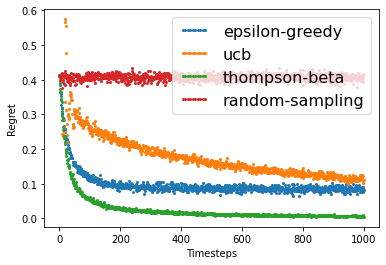

In [7]:
# Experiment 1
arm_count = 10 # number of arms in bandit
epsilon = 0.2
ucb_c = 2
stationary=True
experiment(arm_count)

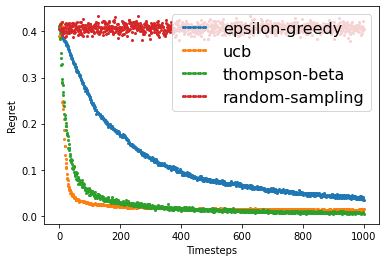

In [8]:
# Experiment 2
arm_count = 10 # number of arms in bandit
epsilon = 0.02
ucb_c = 0.2
stationary=True
experiment(arm_count)

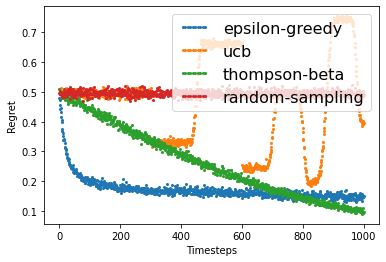

In [9]:
# Experiment 3
arm_count = 300 # number of arms in bandit
epsilon = 0.2
ucb_c = 2
stationary=True
experiment(arm_count)


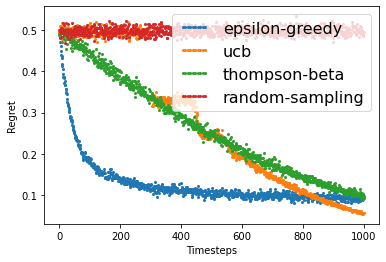

In [10]:
# Experiment 4
arm_count = 300 # number of arms in bandit
epsilon = 0.1
ucb_c = 0.02
stationary=True
experiment(arm_count)

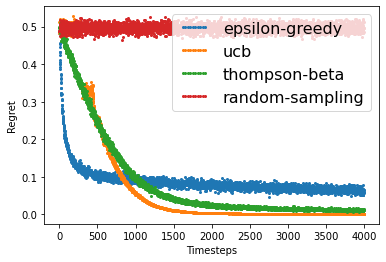

In [11]:
# Experiment 5
arm_count = 300 # number of arms in bandit
epsilon = 0.1
ucb_c = 0.02
stationary=True
experiment(arm_count, timesteps=4000, simulations=1000)

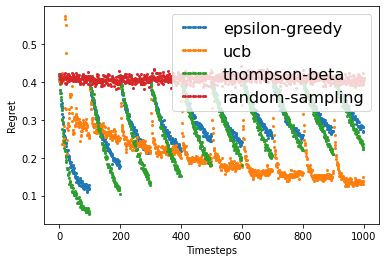

In [12]:
# Experiment 6
arm_count = 10 # number of arms in bandit
epsilon = 0.2
ucb_c = 2
stationary=False
experiment(arm_count)

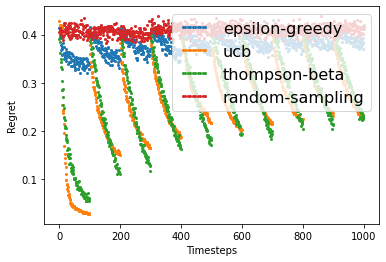

In [13]:
# Experiment 7
arm_count = 10 # number of arms in bandit
epsilon = 0.8
ucb_c = 0.2
stationary=False
experiment(arm_count)

In [27]:
import math
class ThompsonNormal():
  def __init__(self, bandit):
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.alpha = np.ones(self.arm_count)
    self.beta = np.ones(self.arm_count)
    self.mu = np.ones(self.arm_count)
    self.sigma = np.ones(self.arm_count)
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.alpha[arm] += reward
    self.beta[arm] += 1 - reward
    self.mu = self.alpha / (self.alpha + self.beta)
    self.sigma = 1 / (self.alpha + self.beta)

  @staticmethod
  def name():
    return 'normal'
  
  def get_action(self):
    theta = np.random.normal(self.mu, self.sigma)
    return theta.argmax()

In [28]:
def experiment_compare_thompson(arm_count, timesteps=1000, simulations=1000):
  algos = [ ThompsonBeta, ThompsonNormal]
 
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, arm_count, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)

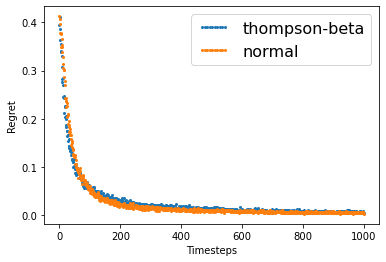

In [29]:
# Experiment 8 : Normal vs. Beta Comparison 
arm_count = 10 # number of arms in bandit
epsilon = 0.02
ucb_c = 0.2
stationary=True
experiment_compare_thompson(arm_count)

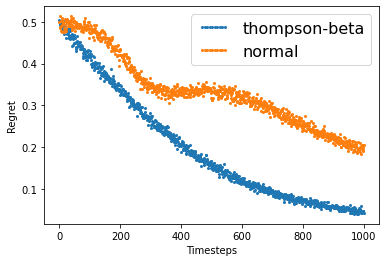

In [30]:
# Experiment 9 : Large Action Space comparison
arm_count = 200 # number of arms in bandit
epsilon = 0.2
ucb_c = 2
stationary=True
experiment_compare_thompson(arm_count)

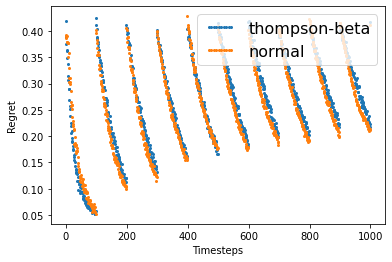

In [31]:
# Experiment 10 : Stationarity comparison
arm_count = 10 # number of arms in bandit
epsilon = 0.2
ucb_c = 2
stationary=False
experiment_compare_thompson(arm_count)